# A PINN of a Poiseuille flow

## Problem set-up

Flow of a liquid through a pipe. 1D rectangular domain, x-axis is the direction of the flow.

Assumptions:
*   One dimensional domain
*   Steady state flow
*   Incompressible fluid
*   Laminar flow
*   No-slip boundary conditions at the walls
*   constant pressure gradient along the x-axis

Governing equations are reduced to:

$$μ * (d²u/dy²) = dp/dx$$  

    where:
*  $u(y)$  is the velocity profile along the y-axis
*  $μ$  is the dynamic viscosity of the fluid
* $dp/dx$  is the constant pressure gradient.

## Neural Network

* Inputs: the collocation points
* Output: the velocity profile   $u(y)$
The pressure is not being solved for directly, but rather it is inputed as a pressure gradient.

### The loss function:

#### Residual loss
Enforces the governing equation
* Calculate the second derivative of the neural networks output $ u $ with respect to $ y $ using automatic differentiation
* evaluate the residual of the governing equation: $$ μ * (d²u/dy²) - dp/dx $$
* calculate its MSE:
$$L_r = (μ * (d²u/dy²) - dp/dx)^2$$

#### Boundary loss
Enforces the boundary conditions
* Evaluate the neural network's output at the boundary points (y = 0 and y= H)
* Calculate the difference between the network's output and the desired boundary values (0, for no-slip walls):
$$ L_b = (u(0)-0)^2 + (u(H)-0)^2 $$

#### Total loss
The total loss is the sum of the residual and boundary losses

In [ ]:
#Import stuff
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

The neural network

ReLU in hidden layers is faster to train both wrt time and accuracy. If all layers have ReLu it doesn't train. Sigmoid and Tanh were tested, with no clear improvement between the two. 

In [ ]:
# Neural Network Model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        #define network architecture
        self.net = nn.Sequential(
            nn.Linear(1, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 1)         #the 1 is the output feature (velocity u)
        )

    #next, define how the input flows through the network.
    # y will be taken and passed through the layers (self.net)
    def forward(self, y):
        return self.net(y)

The loss functions

Here the physics and the boundary loss are defined. Then, inside the train_pinn loop they are combined into the total loss.

In [ ]:
# Loss Function
def physics_loss(model, y, dp_dx, mu):
    u = model(y)    #pass y through the model to get prediciton for u
    #calculate first derivate of u wrt y. Uses torch.autograd.grad to use pytorch's autodifferentiation
    du_dy = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    #calculate second derivate of u wrt y
    d2u_dy2 = torch.autograd.grad(du_dy, y, grad_outputs=torch.ones_like(du_dy), create_graph=True)[0]
    # get the residual of the physics loss
    residual = mu * d2u_dy2 - dp_dx
    return torch.mean(residual**2)   # residual is returned as the MSE

def boundary_loss(model, y):
    u_boundary = model(y)     #pass y through the model to get prediciton for u at the boundary points
    return torch.mean(u_boundary**2)      # boundary loss returned as MSE

The network training loop and a prediction

REALLY doesn't like it when there's a lot of neurons / more neurons than there are collocation points.







Epoch 0, Total Loss: 11331786.0
Epoch 1000, Total Loss: 1224.608642578125
Epoch 2000, Total Loss: 350.34344482421875
Epoch 3000, Total Loss: 291.50140380859375
Epoch 4000, Total Loss: 374.7102966308594
Epoch 5000, Total Loss: 153.11373901367188
Epoch 6000, Total Loss: 117.04753875732422
Epoch 7000, Total Loss: 99.8404312133789
Epoch 8000, Total Loss: 144.5821075439453
Epoch 9000, Total Loss: 62.49656295776367
Epoch 10000, Total Loss: 130.54942321777344
Epoch 11000, Total Loss: 7.819458484649658
Epoch 12000, Total Loss: 6.4089155197143555
Epoch 13000, Total Loss: 5.267477989196777
Epoch 14000, Total Loss: 3.504361629486084
Epoch 15000, Total Loss: 4.3278117179870605
Epoch 16000, Total Loss: 4.179218769073486
Epoch 17000, Total Loss: 4.137779235839844
Epoch 18000, Total Loss: 4.589774131774902
Epoch 19000, Total Loss: 4.611766338348389
Epoch 20000, Total Loss: 3.323209285736084
Epoch 21000, Total Loss: 1.8839595317840576
Epoch 22000, Total Loss: 1.7675437927246094
Epoch 23000, Total Loss

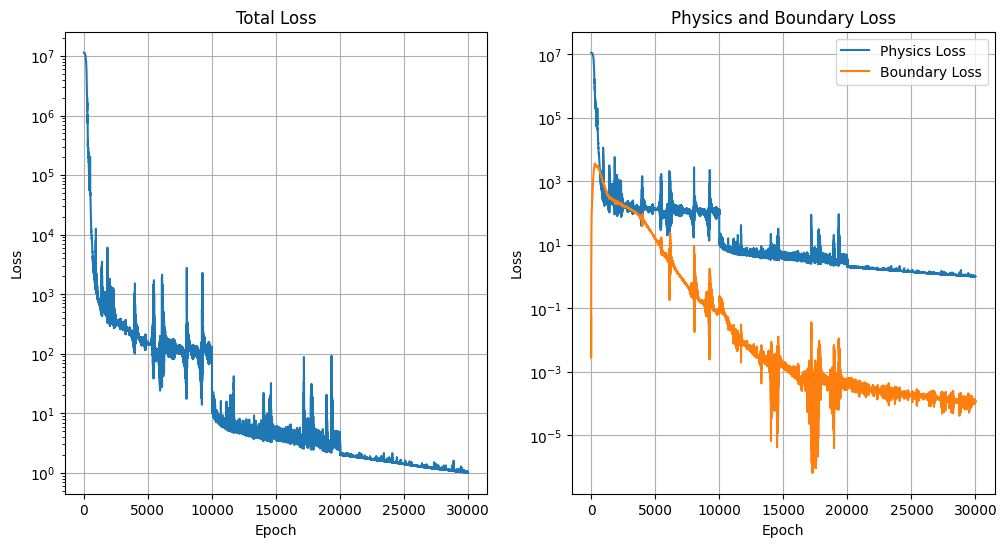

In [ ]:
# Training Loop
def train_pinn(radius, mu, dp_dx, num_collocation_points=100, epochs=30000, lr_drop_epoch=10000):
    model = PINN()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_drop_epoch, gamma=0.1)  # Learning rate scheduler

    # Create distribution for the collocation points.
    #a=b=1 gives uniform distribution
    #a=b->smaller gives more points around boundaries,
    #a=b->higher gives more points around H/2
    a = b = 0.2
    N = num_collocation_points
    # Sample from Beta(a, b) in [0, 1], then scale to [-radius, radius]
    y_dist = np.random.beta(a, b, size=(N, 1))  # Values in [0, 1]
    y_dist = 2 * radius * y_dist - radius       # Rescale to [-radius, radius]

    #Create the collocation and boundary points
    y_collocation = torch.FloatTensor(y_dist)
    y_boundary = torch.FloatTensor(np.array([[-radius], [radius]]))

    y_collocation.requires_grad_(True) #ensure these require gradients
    y_boundary.requires_grad_(True)

    loss_history = []
    physics_loss_history = []
    boundary_loss_history = []

    for epoch in range(epochs):
        optimizer.zero_grad()

        #define the lambdas for giving more weight to either physics or boudary loss
        lambda_physics = 1
        lambda_boundary = 10

        # Compute physics and boundary losses separately
        physics_loss_value = lambda_physics*physics_loss(model, y_collocation, dp_dx, mu)
        boundary_loss_value = lambda_boundary*boundary_loss(model, y_boundary)

        # Combine the losses
        total_loss_value = physics_loss_value + boundary_loss_value

        # Backpropagate it
        total_loss_value.backward()

        # clip the gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update learning rate
        optimizer.step()
        scheduler.step()

        loss_history.append(total_loss_value.item())
        physics_loss_history.append(physics_loss_value.item())
        boundary_loss_history.append(boundary_loss_value.item())

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Total Loss: {total_loss_value.item()}")  #, Physics Loss: {physics_loss_value.item()}, Boundary Loss: {boundary_loss_value.item()}")

    return model, loss_history, y_collocation, physics_loss_history, boundary_loss_history

# Insert the values
radius = 0.05
mu = 0.3094
velocity = 3.4
dp_dx = -8 * mu * velocity / (radius**2)

# Train the PINN
trained_model, loss_history, y_collocation, physics_loss_history, boundary_loss_history = train_pinn(radius, mu, dp_dx)

# Example of plotting the losses
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(loss_history, label="Total Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title("Total Loss")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(physics_loss_history, label="Physics Loss")
plt.plot(boundary_loss_history, label="Boundary Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title("Physics and Boundary Loss")
plt.grid()

plt.legend()
plt.show()

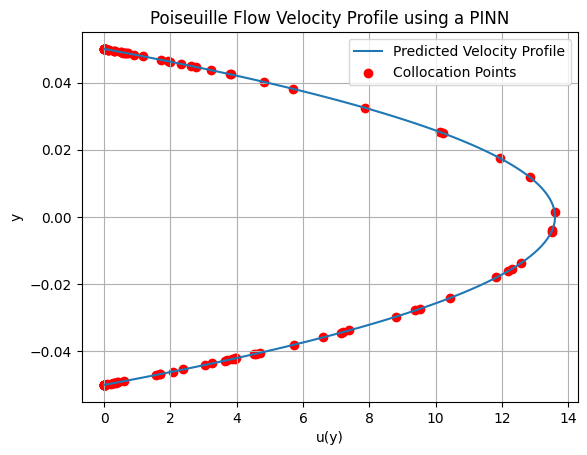

In [ ]:
# Prediction with same radius and velocity

# Prediction function
def predict_velocity_profile(model, radius):
    y_test = torch.FloatTensor(np.linspace(-radius, radius, 100).reshape(-1, 1))
    u_pred = model(y_test).detach().numpy()
    return u_pred, y_test

pred_radius = 0.05
pred_velocity = 3.4

u_pred, y_test  = predict_velocity_profile(trained_model, pred_radius)

# Get predictions for y_collocation to plot them
u_pred_collocation = trained_model(y_collocation).detach().numpy()

#plot the prediction
plt.plot(u_pred, y_test, label='Predicted Velocity Profile')  # Plot the line
plt.scatter(u_pred_collocation, y_collocation.detach().numpy(), color='red', marker='o', label='Collocation Points')  # Scatter plot for collocation points
plt.ylabel("y")
plt.xlabel("u(y)")
plt.title("Poiseuille Flow Velocity Profile using a PINN")
plt.grid()
plt.legend() #add a legend to the plot
plt.show()

Get analytical solution and compare the two

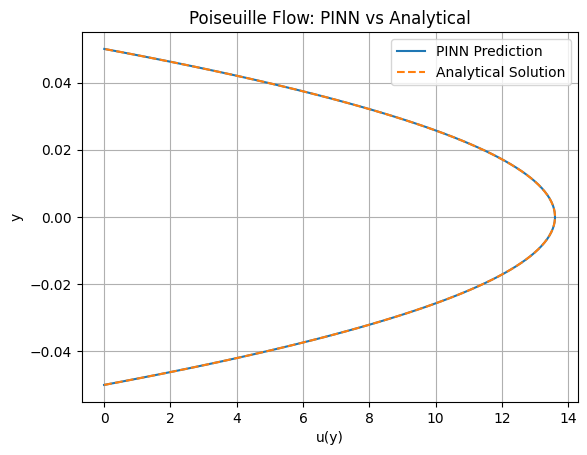

In [ ]:
#Graph Comparison
def analytical_poiseuille(y, dp_dx, mu, radius):
    return (1 / (2 * mu)) * dp_dx * (y**2 - radius**2)


#radius = 0.05
#mu = 0.3094
#velocity = 0.34
#dp_dx = -8 * mu * velocity / (radius**2)

# Generate y values
y_values = np.linspace(-radius, radius, 100)
y_tensor = torch.FloatTensor(y_values).reshape(-1, 1)

# Get PINN predictions from earlier
u_pinn = u_pred

# Get analytical solution
u_analytical = analytical_poiseuille(y_values, dp_dx, mu, radius)

# Plot comparison
plt.plot(u_pinn, y_values, label='PINN Prediction')
plt.plot(u_analytical, y_values, '--', label='Analytical Solution')
plt.xlabel('u(y)')
plt.ylabel('y')
plt.title('Poiseuille Flow: PINN vs Analytical')
plt.legend()
plt.grid()
plt.show()


Max error at collocation points: 0.003369435667991638
Mean error at collocation points: 0.0027857578825205564
Max relative error: 2656.12939453125
Mean relative error: 108.84133911132812


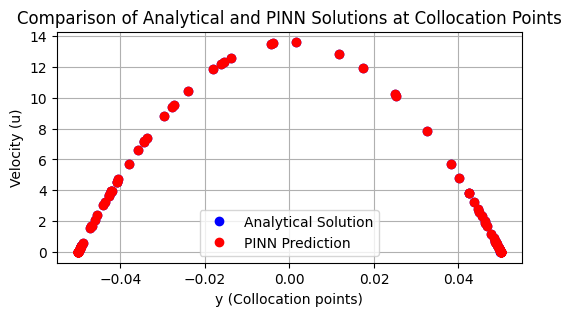

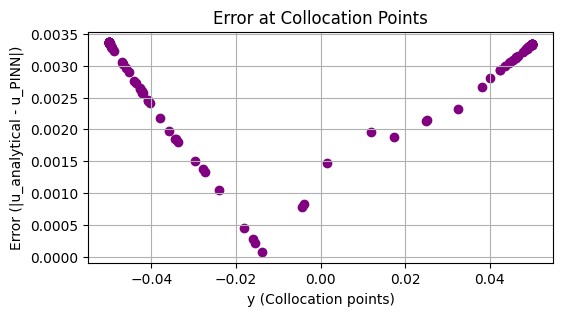

In [ ]:
# Comparison of values at collocation points

# Get the y-collocation points from the training data
y_collocation_values = y_collocation.detach().numpy()

# Calculate the analytical solution at these collocation points
u_analytical_at_collocation = analytical_poiseuille(y_collocation_values, dp_dx, mu, radius)

# Get the PINN predictions at the collocation points
u_pred_at_collocation = trained_model(y_collocation).detach().numpy()

# Compute the absolute error at the collocation points
errors_at_collocation = np.abs(u_pred_at_collocation - u_analytical_at_collocation)

# Print some error statistics (e.g., max error, mean error)
print(f"Max error at collocation points: {np.max(errors_at_collocation)}")
print(f"Mean error at collocation points: {np.mean(errors_at_collocation)}")

# You can also compute relative error
relative_errors = errors_at_collocation / np.abs(u_analytical_at_collocation)
print(f"Max relative error: {np.max(relative_errors)}")
print(f"Mean relative error: {np.mean(relative_errors)}")

# Plot the analytical and PINN solutions at the collocation points
plt.figure(figsize=(6, 3))
plt.plot(y_collocation_values, u_analytical_at_collocation, 'bo', label='Analytical Solution')
plt.plot(y_collocation_values, u_pred_at_collocation, 'ro', label='PINN Prediction')
plt.xlabel('y (Collocation points)')
plt.ylabel('Velocity (u)')
plt.title('Comparison of Analytical and PINN Solutions at Collocation Points')
plt.grid(True)
plt.legend()
plt.show()

# Plot the error at collocation points
plt.figure(figsize=(6, 3))
plt.scatter(y_collocation_values, errors_at_collocation, color='purple')
plt.xlabel('y (Collocation points)')
plt.ylabel('Error (|u_analytical - u_PINN|)')
plt.title('Error at Collocation Points')
plt.grid(True)
plt.show()


Add batches.
The batches for PINNs are done over the collocation points, rather than epochs.

Works better and is faster to bring down the loss.



Epoch 0, Loss: 1133176.5
Epoch 1000, Loss: 5.329543113708496
Epoch 2000, Loss: 9.263738632202148
Epoch 3000, Loss: 8.89913558959961
Epoch 4000, Loss: 8.557642936706543
Epoch 5000, Loss: 8.3742036819458
Epoch 6000, Loss: 8.279312133789062
Epoch 7000, Loss: 8.212362289428711
Epoch 8000, Loss: 8.31583023071289
Epoch 9000, Loss: 8.454553604125977
Epoch 10000, Loss: 0.6597822308540344
Epoch 11000, Loss: 0.3566715717315674
Epoch 12000, Loss: 0.31359684467315674
Epoch 13000, Loss: 0.250432550907135
Epoch 14000, Loss: 0.20058828592300415
Epoch 15000, Loss: 0.16509488224983215
Epoch 16000, Loss: 0.14409257471561432
Epoch 17000, Loss: 0.13601000607013702
Epoch 18000, Loss: 0.01808932237327099
Epoch 19000, Loss: 0.031120311468839645
Epoch 20000, Loss: 0.007102941162884235
Epoch 21000, Loss: 0.0072868443094193935
Epoch 22000, Loss: 0.006695696618407965
Epoch 23000, Loss: 0.006254895124584436
Epoch 24000, Loss: 0.005934178363531828
Epoch 25000, Loss: 0.0056773521937429905
Epoch 26000, Loss: 0.00546

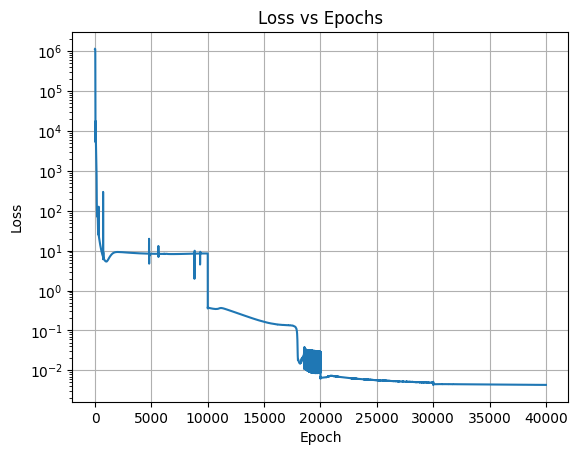

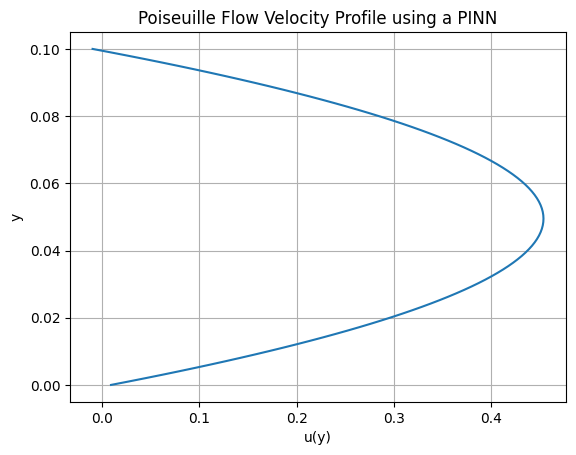

In [ ]:
# Training Loop with batches
def train_pinn(radius, mu, velocity, num_collocation_points=100, epochs=40000, lr_drop_epoch=10000, batch_size= 25):
    model = PINN()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_drop_epoch, gamma=0.1)  # Learning rate scheduler
    H = 2*radius

    y_collocation = torch.FloatTensor(np.random.uniform(0, H, (num_collocation_points, 1)))
    y_boundary = torch.FloatTensor(np.array([[0], [H]]))

    y_collocation.requires_grad_(True) #ensure these require gradients.
    y_boundary.requires_grad_(True)

    loss_history = []

    for epoch in range(epochs):
        dp_dx = -8 * mu * velocity / (radius**2)

        input_boundary = torch.cat((y_boundary, torch.full((2, 1), radius), torch.full((2, 1), velocity)), 1)

        for batch_start in range(0, num_collocation_points, batch_size):
            batch_end = min(batch_start + batch_size, num_collocation_points)
            y_collocation_batch = y_collocation[batch_start:batch_end]

            input_collocation_batch = torch.cat((y_collocation_batch, torch.full((y_collocation_batch.shape[0], 1), radius), torch.full((y_collocation_batch.shape[0], 1), velocity)), 1)

            #define the lambdas for giving more weight to either physics or boudary loss
            lambda_physics = 1
            lambda_boundary = 10

            # Compute physics and boundary losses separately
            physics_loss_value = lambda_physics * physics_loss(model, input_collocation_batch, dp_dx, mu)
            boundary_loss_value = lambda_boundary * boundary_loss(model, input_boundary)

            # Combine the losses
            total_loss_value = physics_loss_value + boundary_loss_value

            optimizer.zero_grad()
            total_loss_value.backward()
            optimizer.step()
        scheduler.step()  # Update learning rate

        loss_history.append(total_loss_value.item())

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss_value.item()}")

    return model, loss_history

# Prediction
def predict_velocity_profile(model, radius, velocity):
    y_test = torch.FloatTensor(np.linspace(0, 2*radius, 100).reshape(-1, 1))
    input_test = torch.cat((y_test, torch.full((100, 1), radius), torch.full((100, 1), velocity)), 1)
    u_pred = model(input_test).detach().numpy()
    return u_pred

# Example Usage
radius = 0.05
mu = 0.3094
velocity = 0.34

trained_model, loss_history = train_pinn(radius, mu, velocity)

plt.plot(loss_history)
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid()
plt.show()

# Prediction with same radius and velocity
new_radius = 0.05
new_velocity = 0.34
u_pred = predict_velocity_profile(trained_model, new_radius, new_velocity)

plt.plot(u_pred, np.linspace(0, 2*radius, 100))
plt.ylabel("y")
plt.xlabel("u(y)")
plt.title("Poiseuille Flow Velocity Profile using a PINN")
plt.grid()
plt.show()